# **The Recommendation Engine Code Instruction**

## **Run the Engine**

### **NOTE: to run the engine using this script, you need to jump to "---- ENGINE SCRIPT---" and run through each component, and then come back to this section!** The code is designed for "BeHoppy" data.

### **User-beer Recommendation**

In [788]:
user = 33

In [789]:
print 'user_id=', user
print 
if user not in users_pred_beers_ratings:
    print 'new users! recommend best beers:'
    best_beers=pd.read_sql_query("select beer, rating, count "
                            "from best_beers limit 10;", local_db)
    print best_beers.head(10)
else:
    pred_beers=pd.read_sql_query("select user_id, beer_id, pred_rating "
                               "from usersReco "
                               "where user_id="+str(user)+" limit 10;", local_db)
    print pred_beers.head(10)

user_id= 33

   user_id  beer_id  pred_rating
0       33        7          5.0
1       33       37          5.0
2       33       56          5.0
3       33       77          5.0
4       33      115          5.0
5       33      147          5.0
6       33      230          5.0
7       33      259          5.0
8       33      270          5.0
9       33     4820          5.0


### **New User coming in! Recommend the best (average) rated beers**

In [778]:
user=1

In [782]:
print 'user_id=', user
print 
if user not in users_pred_beers_ratings:
    print 'new users! recommend best beers:'
    best_beers=pd.read_sql_query("select beer, rating, count "
                            "from best_beers limit 10;", local_db)
    print best_beers.head(10)
else:
    pred_beers=pd.read_sql_query("select user_id, beer_id, pred_rating "
                               "from usersReco "
                               "where user_id="+str(user)+" limit 10;", local_db)
    print pred_beers.head(10)

user_id= 1

new users! recommend best beers:
   beer   rating  count
0   201  4.56667     60
1    10  4.51709    234
2   129  4.45070     71
3   229  4.40230     87
4    94  4.37500     72
5   106  4.37037     54
6    91  4.35484     31
7    32  4.34862    109
8   109  4.34286     70
9  4820  4.32308     65


## **Beer-beer recommendation**

In [790]:
beer_item = 201

In [791]:
print 'beers are similar to beer-', beer_item
                                                     
item_reco=pd.read_sql_query("select beer1, beer2, score "
                            "from similarity where beer1 = "+str(beer_item)+" limit 10;", local_db)
print item_reco.head(10)

beers are similar to beer- 201
   beer1  beer2     score
0    201    201  0.000000
1    201     94  0.162634
2    201     38  0.171473
3    201     27  0.175282
4    201    229  0.254319
5    201    129  0.260824
6    201     35  0.263276
7    201   4820  0.275548
8    201    109  0.278135
9    201     81  0.281885


# **     --------- ENGINE SCRIPT --------   **

### In the following I will explain each of piece of the prduction code in a Python script format. The data are from BeHoppy.

[Python-SQL connector](https://dev.mysql.com/doc/connector-python/en/connector-python-example-cursor-transaction.html)

In [2]:
import numpy as np
import pandas as pd
import pymysql as mdb

source_db = mdb.connect(xxxx)
local_db = mdb.connect(user="root", host="localhost", db="reco-api", charset='utf8')

## **A. The BeHoppy Data**

### **Beer Data**

[Reading SQL query loading in pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_query.html)

### **Note here in the query I only consider the rated beers (there are many unrated beers)**

In [3]:
select_query = ("select beers.id, origins.name as country, flavors.name as flavor, "
               "styles.name as style, average_rating, number_of_ratings, average_aroma_rating, "
               "average_appearance_rating, average_taste_rating, average_body_rating ")

from_query = ("from beers join brands on (beers.brand_id = brands.id) "
                       "join origins on (brands.origin_id = origins.id) "
                       "left join flavors on (beers.flavor_id = flavors.id) "
                       "left join styles on (beers.style_id = styles.id) ")

order_query = "where number_of_ratings > 0 order by id"

beers = pd.read_sql_query(select_query+from_query+order_query+";",source_db)

beers.head()

,id,country,flavor,style,average_rating,number_of_ratings,average_aroma_rating,average_appearance_rating,average_taste_rating,average_body_rating
0,5,BEL,Amadeirado,Lager,3.76380,652,3.49053,3.73823,3.70755,3.42045
1,6,BEL,Doce,Ale,4.18735,427,4.11634,4.17808,4.23014,4.04121
2,7,MEX,Doce,Lager,3.81417,635,3.41279,3.80583,3.70986,3.32879
3,8,BRA,Doce,Bohemian Pilsener,3.71107,488,3.17829,3.41237,3.59278,3.15762
4,9,EUA,Doce,Lager,3.55008,629,3.19721,3.40278,3.48708,3.09562


In [3]:
beers.shape

(2973, 10)

This means there are 9 features for each beer:  country, flavor, styple, average_rating, number_of_ratings, average_aroma_rating, average_appearance_rating, average_taste_rating and average_body_rating (id is the beer-id, excluded from features)

### **Fill up missing (NAN/NA) values [see](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#filling-missing-values-fillna)**

In [6]:
beers = beers.fillna(0)
beers.shape

(3864, 234)

### **Convert categorical variables to dummy variables**

Note the categorical variabels: country, flavor and style are not numerics. We need to introduce dummy (binary) variables, i.e. country = BEL, flavor =Amadeirado for id=5; MEX, Doce for id = 7, and BRA, Doce for id=8, then the feature to represent the country will be (1,0,0..1,0,...), (0,1,0,...0,1,...) and (0,0,1,...0,1,..). The representation is (BEL = 1/0, MEX = 1/0, BRA = 1/0,... , Amadeirado = 1/0, Doce = 1/0..) 

In [7]:
beers = pd.get_dummies(beers)
beers.head()

,id,average_rating,number_of_ratings,average_aroma_rating,average_appearance_rating,average_taste_rating,average_body_rating,country_---,country_ABW,country_AGO,...,style_Standard American Lager,style_Steam Beer,style_Sweet Stout,style_Vienna Lager,style_Weiss,style_Weizen / Weissbier,style_Weizen Doppelbock,style_Wheat Beer,style_Wood Aged Beer,style_Zwickelbier Ale
0,5,3.76380,652,3.49053,3.73823,3.70755,3.42045,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,4.18735,427,4.11634,4.17808,4.23014,4.04121,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,3.81417,635,3.41279,3.80583,3.70986,3.32879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,3.71107,488,3.17829,3.41237,3.59278,3.15762,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,3.55008,629,3.19721,3.40278,3.48708,3.09562,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
beers.shape

(3864, 234)

### **Average and standard deviations of numeric features (over all beers)**

This is to find average number of ratings, average rating of aroma, appeatance, taste and body over all beers. These numbers will be used to mean-normalize the features.

In [8]:
avg_features = beers.mean(axis=0)[2:7].tolist()
print (avg_features)

[9.8647830474268421, 3.5487109552640375, 3.6011405886310111, 3.5874110965354831, 3.433094345778676]


In [9]:
std_features = beers.std(axis=0)[2:7].tolist()
print (std_features)

[33.434190611996307, 1.1866339616711641, 1.1664659711111705, 1.2065632859955246, 1.1811966999146968]


In [10]:
beers.mean(axis=0).head(10)

id                           5986.864110
average_rating                  3.826264
number_of_ratings               9.864783
average_aroma_rating            3.548711
average_appearance_rating       3.601141
average_taste_rating            3.587411
average_body_rating             3.433094
country_---                     0.194080
country_AGO                     0.000336
country_ARG                     0.005045
dtype: float64

### **Ranking rated beers**

This is to rank the beers according to rating (in average). For users who have not tasted any beers, or not been satisfied at beers, recommend these high-score rated beers to the users. Here also consider a filter where the beers are needed to be rated more than **30** times.

In [11]:
avg_beers_rating = beers[['id','average_rating','number_of_ratings']][beers.number_of_ratings>30]
avg_beers_rating.head()

,id,average_rating,number_of_ratings
0,5,3.77752,427
1,6,4.18113,265
2,7,3.83014,418
3,8,3.76923,325
4,9,3.55362,401


Now turn the data frame to a list, in order to sort. Each element is a tuple (beerId, ave_score, rating_times).

In [13]:
avg_beers_rating = [tuple(x) for x in avg_beers_rating.values]
print (avg_beers_rating[:4])

[(5.0, 3.77752, 427.0), (6.0, 4.1811299999999996, 265.0), (7.0, 3.8301400000000001, 418.0), (8.0, 3.7692299999999999, 325.0)]


In [14]:
best_beers = sorted(avg_beers_rating, key=lambda tup: -tup[1])
#print best_beers[:6]
pd.DataFrame(best_beers,  columns=["beer", "ratings", "Nratings"]).head()

,beer,ratings,Nratings
0,79,4.87302,63
1,2671,4.72727,44
2,144,4.67164,67
3,201,4.55621,169
4,39,4.53846,65


Now beers in the **"best_beers"** list is ranked, highest is **beer-79**, rating = 4.833.. second is **beer-87**, rating = 4.8.. If we meet the new users, or users have not been satisfied yet, recommend the beers to them.

### **Rating record table**

In [15]:
ratings = pd.read_sql_query("SELECT score,user_id, beer_id from ratings where user_id is not null or beer_id is not null;",source_db)
ratings.head()

,score,user_id,beer_id
0,4,7,6
1,4,48,7
2,4,47,9
3,4,47,10
4,4,50,9


In [16]:
ratings.shape

(29414, 3)

### **Other data: brands, flavors, users ....**

In [17]:
brands = pd.read_sql_query("SELECT * from brands;",source_db)
brands.head()

,id,name,description,origin_id,created_at,updated_at,profile_picture_file_name,profile_picture_content_type,profile_picture_file_size,profile_picture_updated_at,brewery,group,sourceOfData,purchase_link
0,5,Stella Artois,Stella,1,2015-11-03 21:09:21,2016-05-03 15:21:12,7e30318a-a613-4776-b27c-f32da199ecb2,image/jpeg,367102,2016-03-27 19:56:23,Anheuser Busch Inbev,Anheuser Busch Inbev,Hoppy,http://www.emporiodacerveja.com.br/stella-arto...
1,6,Leffe,Leffe,1,2015-11-18 16:44:35,2016-05-03 15:15:47,e81e8feb-bce1-4160-8fb4-2cc75f7acf71,image/png,1259087,2016-03-27 19:56:36,Ambev,Ambev,Hoppy,http://www.emporiodacerveja.com.br/leffe?utm_s...
2,7,Corona,Corona,4,2015-11-26 12:05:55,2016-05-03 15:09:45,a8308b3f-16b5-4113-b808-f7a6f595f6f0,image/jpeg,5845,2016-03-27 19:56:46,Corona,Corona,Hoppy,http://www.emporiodacerveja.com.br/corona?utm_...
3,8,Antarctica,Antarctica,3,2015-11-26 13:59:31,2016-05-03 15:00:17,None,None,NaN,NaT,Antarctica,Antarctica,Hoppy,http://www.emporiodacerveja.com.br/antarctica?...
4,9,Budweiser,Budweiser,5,2015-11-26 14:01:51,2016-05-03 15:09:03,None,None,NaN,NaT,Budweiser,Budweiser,Hoppy,http://www.emporiodacerveja.com.br/budweiser?u...


In [18]:
flavors = pd.read_sql_query("SELECT * from flavors;",source_db)
flavors.head()

,id,name,description,created_at,updated_at,sourceOfData
0,1,Amadeirado,,2015-10-27 16:25:13,2015-10-27 16:25:13,Hoppy
1,2,Doce,Bem doce,2015-11-03 17:45:10,2015-11-03 17:45:10,Hoppy


In [19]:
users = pd.read_sql_query("SELECT id, first_name, last_name, email from users;",source_db)
users.head()

,id,first_name,last_name,email
0,7,Sergio,Freire,sergiohenriquefp@gmail.com
1,33,Sara,Reinert,sara.reinert@hotmail.com
2,34,Júlia,Neves,jr_neves3@hotmail.com
3,42,Tatiana,Paleckis,tati_paleckis@hotmail.com
4,45,Paula,Guz,paulagguz@gmail.com


In [20]:
users.shape

(10219, 4)

So we can see so far there are 5033 consumers to sign up BeHoppy.

## **B. Construct Vector Space Model**

Here we define the vector space model, where each feature is a dimenion. There are 173 fetures with dummy variables, so the vector space is 173-dimensional.

In [28]:
def build_beers_vector_space(beers_df, beta=0.5):
    '''this method considers loading data directly from pandas daatframe. Note that in this way             
       the first column is the beer-id, and no dataframes' column names will be loaded.
       return:
            vectorSpace[beer] = [attribute1, att2, att3,......]
       '''
    vectorSpace = {}
    irow =0
    for line in beers_df.values:
        irow += 1
        line = tuple(line)
        beer_id = int(line[0])
        #if irow < 10:
        if irow >0:
            if beer_id not in vectorSpace:
                '''line[0] is beer-id, line[1] is the average_ratings which is redundant. 
                   line[2] is the number_of_ratings.... collect features from line[2]
                '''
                vectorSpace[beer_id] = np.asarray([float(line[i]) for i in range(2, len(line))])
                ''' the following is doing mean-normalized, feature = (feature-mean)/std
                    v[0]: num_of_ratings, v[1]:avg_aroma, v[2]:avg_appearance, 
                    v[3]:avg_taste, v[4]:avg_body
                '''
                vectorSpace[beer_id][0] = (vectorSpace[beer_id][0]-avg_features[0])/std_features[0] 
                vectorSpace[beer_id][1] = (vectorSpace[beer_id][1]-avg_features[1])/std_features[1]
                vectorSpace[beer_id][2] = (vectorSpace[beer_id][2]-avg_features[2])/std_features[2]
                vectorSpace[beer_id][3] = (vectorSpace[beer_id][3]-avg_features[3])/std_features[3]
                vectorSpace[beer_id][4] = (vectorSpace[beer_id][4]-avg_features[4])/std_features[4]

    '''normalize the vectors'''
    for beer in vectorSpace:
        v1 = np.asarray(vectorSpace[beer])
        v1 = v1/np.linalg.norm(v1)
        vectorSpace[beer] = v1
            
                
    return vectorSpace

vectorSpace = build_beers_vector_space(beers)

By running the function, each beer is represented in terms of a vector of the space. For example, **beer-id = 5** has the feature: (aroma_rating, appearance_rating, taste_rating, bidy_rating, country_A, country_B.... )

In [24]:
print (vectorSpace[5])

[  1.24763067e+01  -2.09845294e-02   1.20877432e-01   1.30178753e-01
   1.10952344e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00

### **Dimensionality of the vector space (number of attributes of each beer)**

In [25]:
len(vectorSpace[5])

218

### **Number of rated beers (vectors) in the vector space**

In [26]:
len(vectorSpace)

2973

Note that here we implemented the dummy variables, so the vectors looks sparse (only if country=country_A, =1; otherwise =0).

## **C. Beer-Beer Recommendation**

### **Cosine distance similarity**

Here I used the cosine function to define similarity scores, **cosine distance** = (a/|a|-b/|b|)^2. Each beer is a vector in the vector space model, so we can compute cosine to see the similarity between beer-a and beer-b.

In [29]:
def cosine(a,b):
    return 2.0*(1.0-np.dot(a,b.T))#/np.linalg.norm(a)/np.linalg.norm(b))

In [30]:
def similarity():
    '''compute the cosine distance similarity of all paired beer and load the similarity                          
       scores in the SQL database, "similarity" table
       return:
           cosineSim[beer_i] = [(beer_1, si1), (beer_2, si2), (beer_3, si3)...]
    '''
    cosineSim = {}
    for a in vectorSpace:
        vector_a = vectorSpace[a]
        cosineSim[a] = []
        for b in vectorSpace:
            vector_b = vectorSpace[b]
            cosineSim[a].append((b, cosine(vector_a, vector_b)))
        x = cosineSim[a]
        x.sort(key=lambda tup: tup[1])
        cosineSim[a] = x
    
    return cosineSim

    with local_db:
        cur = local_db.cursor()
        cur.execute("DELETE FROM similarity;")
        for beerId1 in cosineSim:
            for beerId2, score in cosineSim[beerId1]:
                query = ("INSERT INTO similarity "
                         "(beer1, beer2, score) "
                         "VALUES (%(beer1)s, %(beer2)s, %(score)s);")
                query_add = {'beer1': beerId1, 'beer2': beerId2, 'score': float(score)}
                cur.execute(query, query_add)
        cur.fetchall()
    
    return cosineSim

cosineSim = similarity()

The following shows the ordered cosine similarity between **beer-5** and others. So **beer-112** is most similar beer to the **beer-5**, and then **beer-7**.... If a consumer likes **beer-10**, then next time we can recommend **beer-112**, **beer-7**, **beer-10**... to the consumer. In other words, here we have **beer-beer recommendation**.
Of course, the rank will be dependent of the weights between the number_of_ratings, rating_scores, and the dummy variables.

### **Beer-Beer recommendatio UI**

### **Beers similar to beer-5**

In [31]:
cosineSim[5][:10]

[(5, 0.0),
 (112, 0.011056594853160906),
 (10, 0.024997502274571426),
 (7, 0.025941778973254337),
 (77, 0.027170262017177649),
 (9, 0.029002684462917649),
 (4818, 0.043441947721272189),
 (69, 0.046810247690564744),
 (8, 0.053630756777816257),
 (11, 0.059607889978050776)]

Of course, we have loaded the similarity in the database, we can also query:

In [32]:
beer5_recommend = pd.read_sql_query("SELECT beer2 from similarity where beer1 = 5 limit 10;", local_db)
beer5_recommend.head()

,beer2
0,5
1,112
2,10
3,7
4,77


### **Beers similar to beer-10**

For **beer-10**, we can recommend similar beers:

In [33]:
cosineSim[10][:10]

[(10, -4.4408920985006262e-16),
 (5, 0.024997502274571426),
 (112, 0.026614350773239481),
 (7, 0.026966197461723018),
 (6, 0.031542020344071275),
 (11, 0.031602143182132503),
 (32, 0.032094908716503001),
 (9, 0.035032634412866859),
 (8, 0.04357060485980857),
 (77, 0.063673940349977087)]

In [34]:
beer10_recommend = pd.read_sql_query("SELECT beer2 from similarity where beer1 = 10 limit 10;", local_db)
beer10_recommend.head()

,beer2
0,10
1,5
2,7
3,112
4,11


## **D. Visualize similar beers**

In [9]:
beers.head()

,id,average_rating,number_of_ratings,average_aroma_rating,average_appearance_rating,average_taste_rating,average_body_rating,country_---,country_ABW,country_AGO,...,style_Standard American Lager,style_Steam Beer,style_Sweet Stout,style_Vienna Lager,style_Weiss,style_Weizen / Weissbier,style_Weizen Doppelbock,style_Wheat Beer,style_Wood Aged Beer,style_Zwickelbier Ale
0,5,3.76380,652,3.49053,3.73823,3.70755,3.42045,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,4.18735,427,4.11634,4.17808,4.23014,4.04121,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,3.81417,635,3.41279,3.80583,3.70986,3.32879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,3.71107,488,3.17829,3.41237,3.59278,3.15762,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,3.55008,629,3.19721,3.40278,3.48708,3.09562,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Remove the columns **id** and **average_rating** which are not going to use in PCA (**average_rating** is redundant since it is linear combination of **average_aroma_rating**,  **average_appearance_rating**, **average_taste_rating** and **average_body_rating**.)

In [10]:
beersPCA = beers.drop(labels=['id', 'average_rating'], axis=1, inplace=False)
beersPCA.head()

,number_of_ratings,average_aroma_rating,average_appearance_rating,average_taste_rating,average_body_rating,country_---,country_ABW,country_AGO,country_ARG,country_AUS,...,style_Standard American Lager,style_Steam Beer,style_Sweet Stout,style_Vienna Lager,style_Weiss,style_Weizen / Weissbier,style_Weizen Doppelbock,style_Wheat Beer,style_Wood Aged Beer,style_Zwickelbier Ale
0,652,3.49053,3.73823,3.70755,3.42045,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,427,4.11634,4.17808,4.23014,4.04121,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,635,3.41279,3.80583,3.70986,3.32879,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,488,3.17829,3.41237,3.59278,3.15762,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,629,3.19721,3.40278,3.48708,3.09562,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Dimensionality reduction to a 2-dimensional space**

### **The process is called principal-component-analysis (PCA)**

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(beersPCA).transform(beersPCA)
print (pca.explained_variance_ratio_)

[ 0.9969571   0.00196904]


/Users/hhhung/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


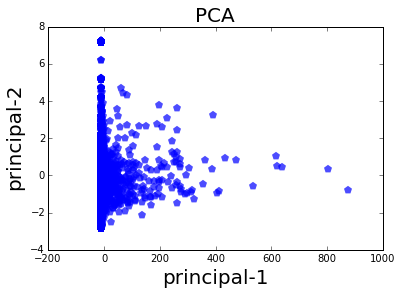

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
x1 = X_r[:,0].tolist()
x2 = X_r[:,1].tolist()

fig, ax = plt.subplots(figsize = (6,4))

ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.cool, linewidths=0, alpha=0.7)
ax.set_xlabel('principal-1', size=20)
ax.set_ylabel('principal-2', size=20)
ax.set_title('PCA', size=20)
plt.show()

/Users/hhhung/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


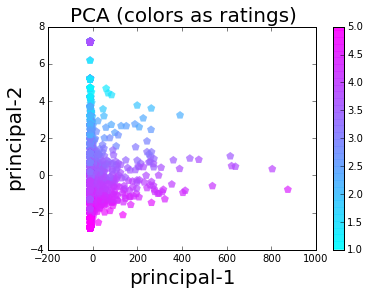

In [18]:
y = beers.loc[:, 'average_rating'].tolist()

fig, ax = plt.subplots(figsize = (6,4))

s = ax.scatter(x1, x2, c = y, s=70, marker=(5, 0), cmap=plt.cm.cool, linewidths=0, alpha=0.7)
plt.colorbar(mappable=s, ax=ax)
ax.set_xlabel('principal-1', size=20)
ax.set_ylabel('principal-2', size=20)
ax.set_title('PCA (colors as ratings)', size=20)
plt.show()

### **Visualize similarity if using beer-10 as reference**

 Beer-10 is the fifth element of the **x1** and **x2** vectors.

In [42]:
print (x1[5], x2[5])

-542.1324669987421 0.577206536360352


In [43]:
len(cosineSim[10]), cosineSim[10][:5]

(2973,
 [(10, -4.4408920985006262e-16),
  (5, 0.024997502274571426),
  (112, 0.026614350773239481),
  (7, 0.026966197461723018),
  (6, 0.031542020344071275)])

In [44]:
similarity_beer10 = cosineSim[10]
similarity_beer10.sort(key=lambda tup: tup[0])
print (similarity_beer10[:10])

[(5, 0.024997502274571426), (6, 0.031542020344071275), (7, 0.026966197461723018), (8, 0.04357060485980857), (9, 0.035032634412866859), (10, -4.4408920985006262e-16), (11, 0.031602143182132503), (12, 0.28041409584315202), (13, 0.42233442563014534), (14, 0.080177421934989113)]


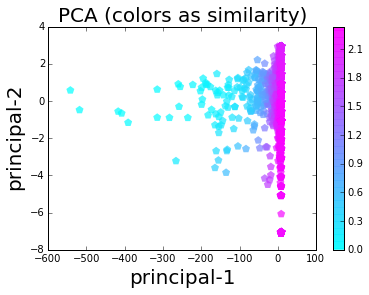

In [45]:
y = [x[1] for x in similarity_beer10]

fig, ax = plt.subplots(figsize = (6,4))

s = ax.scatter(x1, x2, c = y, s=70, marker=(5, 0), cmap=plt.cm.cool, linewidths=0, alpha=0.7)
plt.colorbar(mappable=s, ax=ax)
ax.set_xlabel('principal-1', size=20)
ax.set_ylabel('principal-2', size=20)
ax.set_title('PCA (colors as similarity)', size=20)
plt.show()

### **Visualize if using beer-116 as reference**

In [46]:
print (x1[100], x2[100])

-0.14096420015793576 0.7755331222193884


In [47]:
similarity_beer116 = cosineSim[116]
similarity_beer116.sort(key=lambda tup: tup[0])

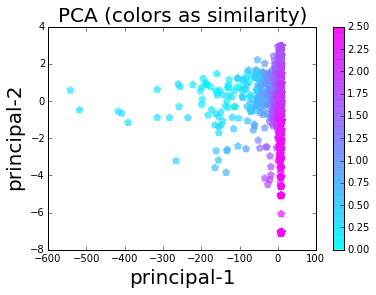

In [48]:
y = [x[1] for x in similarity_beer116]

fig, ax = plt.subplots(figsize = (6,4))

s = ax.scatter(x1, x2, c = y, s=70, marker=(5, 0), cmap=plt.cm.cool, linewidths=0, alpha=0.7)
plt.colorbar(mappable=s, ax=ax)
ax.set_xlabel('principal-1', size=20)
ax.set_ylabel('principal-2', size=20)
ax.set_title('PCA (colors as similarity)', size=20)
plt.show()

## ** E. User-Item Recommendation using Models**

Recall that we have a rating data:

In [763]:
ratings.head()

,score,user_id,beer_id
0,4,7,6
1,4,48,7
2,4,47,9
3,4,47,10
4,4,50,9


In [764]:
ratings.shape

(9800, 3)

### **User rating records**

The content-based model is essentially to set up each user as an individual machine learning problem. Different users have different tastes on beers, so they will have different preferences. In the following, we create the **users_beers_ratings** dictionary to store each users' rating history.

In [49]:
def users_ratings():
    '''This function is used tp prepare users' rating history
       return:
            user_beers_ratings[user] = [beer1:r1,beer2:r2, beer3:r3,...]
    ''' 
    users_beers_ratings = {}
    for line in ratings.values:
        line = tuple(line)
        user_id = int(line[1])
        beer_id = int(line[2])
        score = line[0]
        if user_id not in users_beers_ratings:
            #users_beers_ratings[user_id] = [(beer_id, float(score))]
            users_beers_ratings[user_id] = {beer_id:float(score)}
        else:
            #users_beers_ratings[user_id].append((beer_id, float(score)))
            users_beers_ratings[user_id][beer_id] = float(score)
            
    return users_beers_ratings     

users_beers_ratings = users_ratings()

For example, for **user-id =47** user, he/she has rated the beers:

In [50]:
users_beers_ratings[47]

{7: 5.0, 9: 4.0, 10: 4.0, 11: 5.0, 94: 5.0, 152: 5.0, 202: 4.0}

How many consumers have used the BeHoppy to rate beers?

In [52]:
print ('The number of users rated =', len(users_beers_ratings))

The number of users rated = 3260


Who has rated most beers in the BeHoppy?

In [54]:
max_ratings = -1
max_user = None
for user in users_beers_ratings:
    if len(users_beers_ratings[user]) > max_ratings:
        max_ratings = len(users_beers_ratings[user])
        max_user = user
print (max_user, max_ratings)

3494 630


In [55]:
users[users.id == max_user]

,id,first_name,last_name,email
3441,3494,Carla,Daniele,caahniele@yahoo.com.br


The consumer Carla (user-id=3494) has rated beers including:

In [57]:
irow =0 
for beer in users_beers_ratings[max_user]:
    if irow < 10: print ('beer:', beer, 'rating:',users_beers_ratings[max_user][beer])
    irow += 1

beer: 171 rating: 1.0
beer: 5 rating: 1.0
beer: 6 rating: 4.0
beer: 7 rating: 3.0
beer: 8 rating: 1.0
beer: 9 rating: 1.0
beer: 10 rating: 5.0
beer: 6155 rating: 3.0
beer: 12 rating: 4.0
beer: 13 rating: 4.0


## **(A) Logistic Regression**

In [58]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn import grid_search

In [60]:
def decision_tree(X_train, y_train, X_test, y_test):
    '''http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'''
    print ('doing machine learning: tree')
    clf = DecisionTreeClassifier(random_state=0)
    cv_error = cross_val_score(clf, X_train, y_train, cv=5)
    print (cv_error, np.mean(cv_error))
    clf.fit(X_train, y_train)
    print (clf.predict(X_test))
    #print clf.predict_proba(X_test)[:,1]
    print (y_test, clf.score(X_test, y_test))

In [106]:
def logistic_regression(X_train, y_train, X_test, y_test, accuracy):
    #print 'doing machine learning: logistic regression'
    '''logistic regression 
    http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.get_params'''
    
    if len(y_train) - sum(y_train) < 5 or sum(y_train) == 5:
        '''This is used to guarantee the number of y=0 or y=1 should be more than 5.
           Otherwise sklearn is not able to build models.
        '''
        print ('NOT able to do classification, no enough y=0 or y=1')
        print (sum(y_train), len(y_train))
        return
        
    best_model = None
    min_error = 10000
    for regularization_param in [0.0001, 0.01, 0.1,1,10,100,1000, 10000, 100000]:
        logreg = linear_model.LogisticRegression('l2', C=regularization_param)
        cv_error = cross_val_score(logreg, X_train, y_train, cv=5)
        if np.mean(cv_error) < min_error:
            min_error = np.mean(cv_error)
            best_model = logreg

    #print best_model.predict(X_test)
    best_model.fit(X_train, y_train)
    print (len(y_test), best_model.score(X_test, y_test))
    #print len(best_model.coef_[0])
    
    accuracy[0] += len(y_test)*best_model.score(X_test, y_test)
    accuracy[1] += len(y_test)
    
    return best_model

In [96]:
preference = {1:0, 2:0, 3:0, 4:1, 5:1}

### **Performance of clasification if 100 observations**

In [80]:
accuracy = [0]*2
users_models = {}
for user in users_beers_ratings:
    #print (user, len(users_beers_ratings[user]))
    #continue
    if  len(users_beers_ratings[user]) > 100:
        X = []
        y = []
        for beer in users_beers_ratings[user]:
            #print beer, rating, type(rating)
            rating = users_beers_ratings[user][beer]
            X.append(vectorSpace[beer])
            y.append(preference[rating])
        X = np.asarray(X)
        y = np.asarray(y)
        print ('user=', user, ', n_data=', len(y))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
        #decision_tree(X_train, y_train, X_test, y_test)
        model = logistic_regression(X_train, y_train, X_test, y_test, accuracy)
        
        users_models[user] = model
        print ('-------------------------------------')

print (accuracy[0]/accuracy[1])

user= 112 , n_data= 103
34 0.735294117647
-------------------------------------
user= 9177 , n_data= 125
42 0.952380952381
-------------------------------------
user= 1440 , n_data= 164
55 0.636363636364
-------------------------------------
user= 9834 , n_data= 164
55 0.654545454545
-------------------------------------
user= 2600 , n_data= 118
39 0.769230769231
-------------------------------------
user= 8546 , n_data= 128
43 0.674418604651
-------------------------------------
user= 10070 , n_data= 370
123 0.739837398374
-------------------------------------
user= 3494 , n_data= 630
208 0.610576923077
-------------------------------------
user= 3510 , n_data= 120
40 0.775
-------------------------------------
user= 3556 , n_data= 134
45 0.577777777778
-------------------------------------
user= 4328 , n_data= 115
38 0.763157894737
-------------------------------------
user= 4632 , n_data= 469
155 0.61935483871
-------------------------------------
user= 4718 , n_data= 158
53 0.66037

### **Visualize similarity vs ratings**

In [71]:
def rating_vs_sim(x1, x2):
    fig, ax = plt.subplots(figsize = (6,4))
    s = ax.scatter(x2, x1, s=70, marker=(5, 0), cmap=plt.cm.cool, linewidths=0, alpha=0.7)
    ax.set_xlabel('sim(user, beer)', size=20)
    ax.set_ylabel('rating(user, beer)', size=20)
    ax.set_title('relation between user and beers', size=20)
    plt.show()

### **More observations, better performance**

In [81]:
user_preference = users_models[3494].coef_[0]

In [82]:
x1 = []
x2 = []
irow =0
for beer in users_beers_ratings[3494]:
    rating = users_beers_ratings[3494][beer]
    #if rating > 3.0: print beer, rating, cosine(vectorSpace[beer].T, user_preference)
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    irow += 1
    if rating > 3.0 and irow <30: print (beer, rating, cosine(vectorSpace[beer].T, user_preference))

6 4.0 1.99789489331
10 5.0 1.9987462047
12 4.0 1.99597839338
13 4.0 1.99893801048
5144 5.0 1.99122513427
28 4.0 1.99274157796
9050 4.0 1.99962198176
9221 5.0 2.00082091913
32 4.0 1.99772532114
34 4.0 1.99662473663
35 5.0 1.99768574191
3078 5.0 1.99127323512
38 4.0 1.99722453886
39 5.0 1.99258040349
9256 5.0 1.99378960113


In [83]:
irow =0
for beer in users_beers_ratings[3494]:
    rating = users_beers_ratings[3494][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    irow += 1
    if rating <= 3.0 and irow <30: print (beer, rating, cosine(vectorSpace[beer].T, user_preference))

171 1.0 2.01047963878
5 1.0 1.99960066801
7 3.0 1.999750986
8 1.0 2.00011263287
9 1.0 2.00012633561
6155 3.0 1.996983802
14 2.0 1.99977568581
15 3.0 1.99981482676
16 3.0 1.99806674303
17 2.0 2.00131066449
22 1.0 2.00650777114
25 2.0 2.00348643767
27 3.0 1.99805407461
5153 3.0 1.99783374042


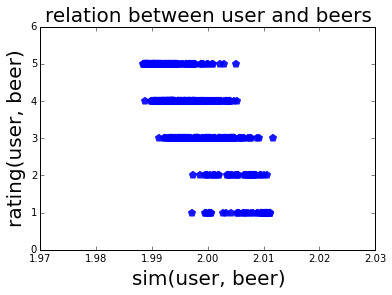

In [84]:
rating_vs_sim(x1, x2)

### **Less observation, unstable performance: ~ 100 samples**

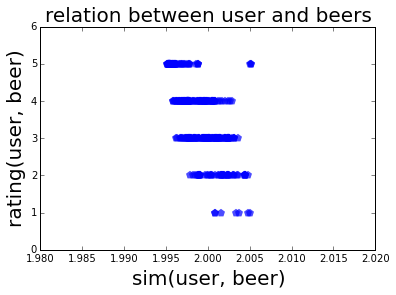

In [87]:
user_preference = users_models[10070].coef_[0]
x1 = []
x2 = []
for beer in users_beers_ratings[10070]:
    rating = users_beers_ratings[10070][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    
rating_vs_sim(x1, x2)    

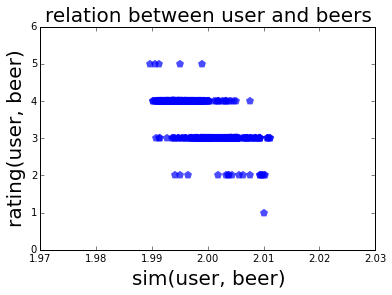

In [88]:
user_preference = users_models[5608].coef_[0]
x1 = []
x2 = []
for beer in users_beers_ratings[5608]:
    rating = users_beers_ratings[5608][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    
rating_vs_sim(x1, x2)

### **Worse performance of clasification if only allowing 50 observations**

In [107]:
users_models = {}

accuracy = [0,0]

for user in users_beers_ratings:
    if  100> len(users_beers_ratings[user])> 50:
        X = []
        y = []
        for beer in users_beers_ratings[user]:
            #print beer, rating, type(rating)
            rating = users_beers_ratings[user][beer]
            X.append(vectorSpace[beer])
            y.append(preference[rating])  ## preference convert rating >3 to y=1, rating <=3 to y=0
        X = np.asarray(X)
        y = np.asarray(y)
        print ('user=', user, len(y))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
        #decision_tree(X_train, y_train, X_test, y_test)
        model = logistic_regression(X_train, y_train, X_test, y_test, accuracy)
        
        users_models[user] = model
        print ('-------------------------------------')

print (accuracy[0]/accuracy[1])

user= 8228 66
22 0.5
-------------------------------------
user= 55 86
29 0.793103448276
-------------------------------------
user= 8340 68
23 0.521739130435
-------------------------------------
user= 292 95
32 0.6875
-------------------------------------
user= 8882 59
20 0.7
-------------------------------------
user= 8903 77
26 0.846153846154
-------------------------------------
user= 9809 87
29 0.655172413793
-------------------------------------
user= 1769 59
20 0.8
-------------------------------------
user= 9982 64
22 0.5
-------------------------------------
user= 10046 52
18 0.555555555556
-------------------------------------
user= 1987 53
18 0.611111111111
-------------------------------------
user= 2369 64
22 0.863636363636
-------------------------------------
user= 2559 58
NOT able to do classification, no enough y=0 or y=1
34 38
-------------------------------------
user= 2754 51
17 0.117647058824
-------------------------------------
user= 2877 62
21 0.666666666667
--

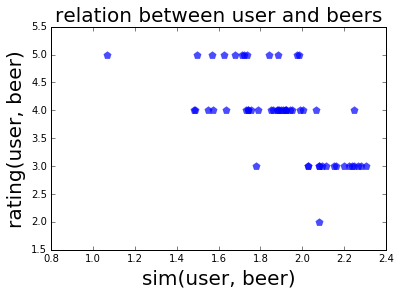

In [707]:
user_preference = users_models[1769].coef_[0]
x1 = []
x2 = []
for beer in users_beers_ratings[1769]:
    rating = users_beers_ratings[1769][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    #print beer, rating, cosine(vectorSpace[beer].T, user_preference)
    
rating_vs_sim(x1, x2)

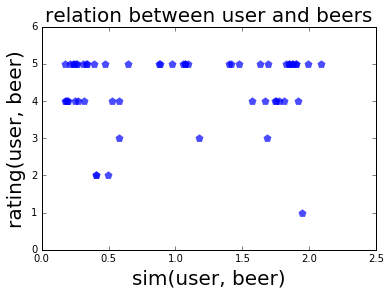

In [705]:
user_preference = users_models[112].coef_[0]
x1 = []
x2 = []
for beer in users_beers_ratings[112]:
    rating = users_beers_ratings[112][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    
rating_vs_sim(x1, x2)

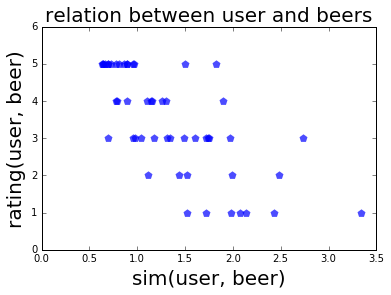

In [706]:
user_preference = users_models[2754].coef_[0]
x1 = []
x2 = []
for beer in users_beers_ratings[2754]:
    rating = users_beers_ratings[2754][beer]
    x1.append(rating)
    x2.append(cosine(vectorSpace[beer].T, user_preference))
    
rating_vs_sim(x1, x2)

### The logistic regression models suffer the problem where data amount is not enough. The second approach is to consider the neighborhood model, to predict beers' ratings for a given user.

## **(B) Neighborhood model**

In the neighborhoold, rather than building a predictive model (logistic regression), we used users' historial ratings to predict an item's predicted rating given by the user. The way is

$$\hat{R}_{ui} = \frac{\sum_{j\in S^u} w_{ij}R_{uj}}{\sum_{j \in S^u} \lvert w_{ij}\lvert}.$$

The $S^u$ denotes a set of the beers the user $u$ rated; the corresponding ratings are $\lbrace R_{u1}, R_{u2},\cdots\rbrace$. $w_{ij}$ is the weight between **beer-i** and **beer-j** which is defined as $w_{ij} = 1-s_{ij}/2$, where $s_{ij}$ is the similarity score. The physical meaning of the neighborhood model is that if **beer-j** is farther away from **beer-i** ($s_{ij}$ is larger); they are less similar, then the rating of **beer-j** has less contribution ($w_{ij}$ is smaller) to predicting **beer-i** rating. Cusomers always like items which are similar each other.

In [94]:
def neighborhood(k_neighbors=200):
    '''Using neighborhood methods to predict the ratings of unrated beers for a given
       user. k_neighbors is to control how many neighbors to include for the predictions.
       return:
          users_pred_beers_ratings[user] = [(beer1, r1), (beer2, r2), (beer3, r3)...]
    '''
    error = 0.0
    repeat_pred = 0
    users_pred_beers_ratings = {}

    #  ------------ using this query to generate loops is slow -----
    #beer_ids = beers[['id']]
    #for beer1 in beer_ids.values:
    #    beer1 = beer1[0]
    #    item1=pd.read_sql_query("select beer1, beer2, score "
    #                        "from similarity where beer1 = "+str(beer1)+" limit "
    #                        " "+str(k_neighbors)+";", local_db)
    #    similarity_weight ={}
    #    for line in item1.values:
    #        beer2 = int(line[1])
    #        similarity_weight[beer2] = 1.0 - line[2]/2.0
    # ----------------------------------------------------------------
    
    
    for beer1 in cosineSim:

        weight ={}
        for beer2, similarity in cosineSim[beer1][1:k_neighbors+1]:
            weight[beer2] = 1.0 - similarity/2.0

        for user in users_beers_ratings:
            
            beer1_pred_rating =0.0
            norm_sim = 0.0
            for beer2 in users_beers_ratings[user]:
                if beer2 in weight:
                    '''Note we will encounter TWO situations where no beer_2 in similarity_weight: 
                        (1) beer_2 has rating by users, but has not been characterized attributes yet, 
                            i.e. in "beers" table it doesn't exist. So in the similarity table as well as
                            similarity_weight, no beer1-beer2 record exists.
                        (2) beer2 has been characterized attributes in "beers" table, so has beer1-beer2 
                            similairty. However, the similarity is not significant such that beer-2 is not 
                            in the set of k-neighbors.
                        In both cases, we will have norm_sim = beer1_pred_rating = 0
                    '''
                    rating = users_beers_ratings[user][beer2]
                    beer1_pred_rating += weight[beer2]*rating
                    norm_sim += abs(weight[beer2])
                    '''the above procedures are doing sum_j (s_{ij}*r_{uj}) and sum_j |s_{ij}|'''

            '''as above, if norm_sim=beer1_pred_rating=0: no predicted rating available'''
            if norm_sim == 0 or beer1_pred_rating < 0:
                beer1_pred_rating = 0
            else:    
                beer1_pred_rating = beer1_pred_rating/norm_sim


            if beer1_pred_rating >0:
                if beer1 not in users_beers_ratings[user]:
                    if user not in users_pred_beers_ratings:
                        users_pred_beers_ratings[user] = [(beer1, beer1_pred_rating)]
                    else:
                        users_pred_beers_ratings[user].append((beer1, beer1_pred_rating))
                else:
                    error += abs(beer1_pred_rating-users_beers_ratings[user][beer1])
                    repeat_pred += 1

    '''users_pred_beers_ratings[user] = [(beer1, r1), (beer2, r2), (beer3, r3)...]
       now, we need to put it in order according to ratings, r1>= r2>=....:
    '''
    for user in users_pred_beers_ratings:
        x = users_pred_beers_ratings[user]
        x.sort(key=lambda tup: -tup[1])
        users_pred_beers_ratings[user] = x


    return error/float(repeat_pred), users_pred_beers_ratings


    with local_db:
        print ('start loading into usersReco')
        cur = local_db.cursor()
        cur.execute("DELETE FROM usersReco;")
        for user in users_pred_beers_ratings:
            for beer, rating in users_pred_beers_ratings[user][:30]:
                '''NOTE: doing int(beer), otherwise beer is in "numpy.int64" attribute.'''
                query = ("INSERT INTO usersReco "
                           "(user_id, beer_id, pred_rating) "
                           "VALUES (%(user_id)s, %(beer_id)s, %(pred_rating)s);")
                query_add = {'user_id': user, 'beer_id': int(beer), 'pred_rating': float(rating)}
                cur.execute(query, query_add)
        cur.fetchall()
        print ('loading usersReco is done')


    return error/float(repeat_pred), users_pred_beers_ratings


MAE, users_pred_beers_ratings = neighborhood(k_neighbors = 200)
print ('mean absolute error =', MAE)

mean absolute error = 0.681404558854
